In [1]:
from rainymotion import models, metrics, utils
from collections import OrderedDict
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = h5py.File("../../data/data.h5", mode="r")  # "data.h5" (mode r)
# dictionary structure: {"t": [ [t-24, t-23,..., t-1], [t+1,...,t+12] ]}
eval_idx = np.load("../../data/eval_dict.npy",allow_pickle=True).item()

In [4]:
eval_instance = eval_idx
data_instance = data
model = models.SparseSD()

if True:
    key = sorted(list(eval_instance.keys()))[0]    
#for key in sorted(list(eval_instance.keys())):
    inputs = np.array([ data_instance[key][:] for key in eval_instance[key][0] ])
    model.input_data = inputs
    nowcast = model.run()  # shape (12, 900, 900)

In [5]:
model.of_params

{'st_pars': {'maxCorners': 200,
  'qualityLevel': 0.2,
  'minDistance': 7,
  'blockSize': 21},
 'lk_pars': {'winSize': (20, 20), 'maxLevel': 2, 'criteria': (3, 10, 0)}}

In [6]:
self = model

In [7]:
import skimage.transform as sktf
from rainymotion.models import _sparse_linear,_sparse_sd
transformations = {'euclidean': sktf.EuclideanTransform(),
                   'similarity': sktf.SimilarityTransform(),
                   'affine': sktf.AffineTransform(),
                   'projective': sktf.ProjectiveTransform()}

# scale input data to uint8 [0-255] with self.scaler
data_scaled, c1, c2 = self.scaler(self.input_data) # shape (24, 900, 900)

# set up transformer object
trf = transformations[self.warper]  # 3x3 transform matrix

# obtain source and target points
if self.extrapolation == "linear":
    pts_source, pts_target_container = _sparse_linear(data_instance=data_scaled,
                                                      of_params=self.of_params,
                                                      lead_steps=self.lead_steps)
elif self.extrapolation == "simple_delta":
    pts_source, pts_target_container = _sparse_sd(data_instance=data_scaled,
               of_params=self.of_params, lead_steps=self.lead_steps) # (128,2),12 elements of (128,2) 

# container for our nowcasts
last_frame = data_scaled[-1]
nowcst_frames = []

for lead_step, pts_target in enumerate(pts_target_container):

    # estimate transformation matrix
    # based on source and traget points
    trf.estimate(pts_source, pts_target)

    # make a nowcast
    nowcst_frame = sktf.warp(last_frame/255, trf.inverse)
    # transformations dealing with strange behaviour
    nowcst_frame = (nowcst_frame*255).astype('uint8')
    # add to the container
    nowcst_frames.append(nowcst_frame)

nowcst_frames = np.stack(nowcst_frames, axis=0)

nowcst_frames = self.inverse_scaler(nowcst_frames, c1, c2)

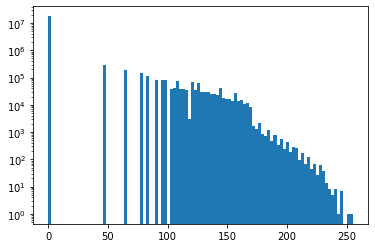

In [8]:
plt.hist(data_scaled.flatten(),100)
plt.yscale('log')
plt.show()

In [9]:
nowcast.shape

(12, 900, 900)

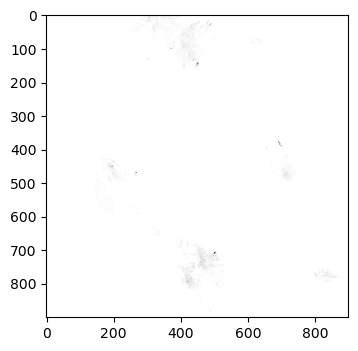

In [10]:
plt.figure(dpi = 100)
plt.imshow(nowcast[0], cmap='gray_r')
plt.show()

In [13]:
data_instance = data_scaled  # (24, 900, 900)

In [20]:
import cv2
of_params={'st_pars': dict(maxCorners = 200,qualityLevel = 0.2,minDistance = 7,blockSize = 21),
            'lk_pars': dict(winSize = (20, 20),maxLevel = 2,
                            criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0))}
lead_steps=12

# define penult and last frames
penult_frame = data_instance[-2]
last_frame = data_instance[-1]

# find features to track
old_corners = cv2.goodFeaturesToTrack(data_instance[0], mask=None,**of_params['st_pars']) # (200,1,2)

# track corners by optical flow algorithm
new_corners, st, err = cv2.calcOpticalFlowPyrLK(prevImg=penult_frame,nextImg=last_frame,
                                                prevPts=old_corners,nextPts=None,**of_params['lk_pars'])
# (200,1,2),   (200,1), (200,1)

# select only good attempts for corner tracking
success = st.ravel() == 1
new_corners = new_corners[success].copy()  # (128,1,2)
old_corners = old_corners[success].copy()

# calculate Simple Delta
delta = new_corners.reshape(-1, 2) - old_corners.reshape(-1, 2)  # (128,2)

# simplificate furher transformations
pts_source = new_corners.reshape(-1, 2)  # (128,2)

# propagate our corners through time
pts_target_container = []

for lead_step in range(lead_steps):
    pts_target_container.append(pts_source + delta * (lead_step + 1)) # assume the corner will continue to move

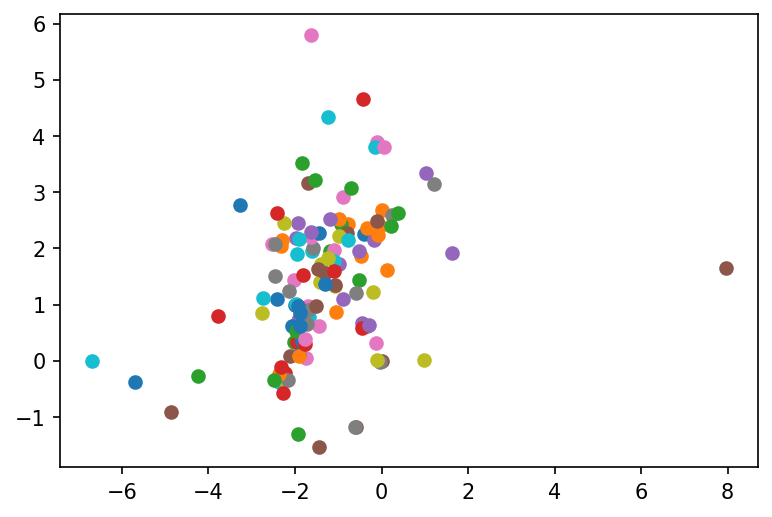

In [38]:
plt.figure(dpi = 150)
for (x,y) in delta:
    plt.plot(x,y,'o')